Problem Statement:

Able to work, but cannot sample too much. Increasing the number of samples (N), for example, from $N=50$ to $N \ge 300$, causes the program to crash due to insufficient memory, resulting in a solver error or immediate process termination.

Reason:

The solver, in implementing the dual form of this problem (Corollary 3.3) as a Second-Order Cone Program (SOCP), requires constructing and manipulating large internal matrices. Due to the high degree of coupling introduced by the $p^+$ and $p^-$ dual variables, the memory requirement for these internal structures scales non-linearly.

先一下子纯粹的得到过去6个历史点的数据，然后根据这些历史点拟合，从而预测7时的数据。然后再从6时继续漂移，取8飘逸，每次飘逸都得到一个7时的数据，对这8个飘逸的可能性分别和前面的预测值相比，计算损失，然后这8种损失做平均。也就是期望损失。然后这时候我换一些参数，比如说我wasserstein的半径调整一下，或者我给不同历史点的sample的权重衰减速度变化一下之类的，重新做一遍，从一下子得到7个历史点那里开始，最后我得到了不同参数下的期望损失，取最小的期望损失作为ex-post optimal，对应的就是最好的wasserstein半径或者衰减速度。这是一次simulation。 然后下一次，我不修改drift parameter的bound，然后将上面一整段的内容重新做一遍。这样就是相同drift parameter下不同6个历史点的数据，得到也是一个ex-post optimal。 这样的simulation我做5次，最后就是得到了5个ex-post optimal，然后取平均，就是我的全局平均性能。

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
# ---------- Helper Functions: box uncertainty set & weighting factor ----------

# 1. Construct the box-shaped uncertainty set Ξ (axis-aligned hyper-rectangle)
def build_box_uncertainty(Z_all, qmin=0.01, qmax=0.99, eta=0.02):
    """return [ell, upp] in each dimension of Z_all"""
    low  = np.quantile(Z_all, qmin, axis=0)
    high = np.quantile(Z_all, qmax, axis=0)
    span = high - low
    ell  = low  - eta * span
    upp  = high + eta * span
    # Avoid zero-width intervals
    upp = np.maximum(upp, ell + 1e-10)
    return ell, upp

def build_box_conic_from_bounds(ell, upp, n):
    """
    Rewrite the box uncertainty set  Ξ = { (x,y): ell <= (x,y) <= upp }
    into the form C1 x + c2 y <= d   (C is the nonnegative orthant cone), for direct use of Corollary 3.3.
    Return C1 (m*n), c2 (m,), d (m,), where m = 2*(n+1)
    where n = dim(x), y is a scalar
    """
    m = 2*(n+1)
    C1 = np.zeros((m, n))
    c2 = np.zeros(m)
    d  = np.zeros(m)

    row = 0
    # upper bound： x_j <= upp_j
    for j in range(n):
        C1[row, j] = 1.0
        d[row] = upp[j]
        row += 1
    # lower bound： -x_j <= -ell_j
    for j in range(n):
        C1[row, j] = -1.0
        d[row] = -ell[j]
        row += 1
    # upper bound for y： y <= upp_y
    c2[row] = 1.0
    d[row] = upp[n]
    row += 1
    # lower bound for y： -y <= -ell_y
    c2[row] = -1.0
    d[row] = -ell[n]
    row += 1

    assert row == m
    return C1, c2, d

# 2. Compute time-dependent sample weights (exponential forgetting)
def time_weights_from_indices(time_idx, now_t, decay):
    raw = decay ** (now_t - time_idx)
    pi = raw / raw.sum()
    return pi

# 3. DRO ε-insensitive SVR
# ---------- Core：DRO-SVR following Corollary 3.3 ----------
def solve_dro_svr_cor33(X, y, C1, c2, d, pi, epsilon=60000.0, rho=0.5, use_mosek=True):
    """
    Corollary 3.3 (Support Vector Regression):
      min   λ ρ + sum_i π_i s_i
      s.t.  y_i - <w,x_i> - ε + <p_i^+, d - C1 x_i - c2 y_i> <= s_i
            <w,x_i> - y_i - ε + <p_i^-, d - C1 x_i - c2 y_i> <= s_i
            || ( C1^T p_i^+ + w ,  c2^T p_i^+ - 1 ) ||_* <= λ
            || ( C1^T p_i^- - w ,  c2^T p_i^- + 1 ) ||_* <= λ
            p_i^+, p_i^- >= 0,  s_i >= 0
    """
    N, n = X.shape
    m = C1.shape[0]  # number of constraints (2*(n+1))

    w   = cp.Variable(n)
    lam = cp.Variable(nonneg=True)
    s   = cp.Variable(N, nonneg=True)

    constraints = []

    # pre-calculate (d - C1 x_i - c2 y_i) for each sample
    D_minus_Axi_cy = (d[None, :] - X @ C1.T - np.outer(y, c2))  # (N,m)

    for i in range(N):
        p_plus_i  = cp.Variable(m, nonneg=True)
        p_minus_i = cp.Variable(m, nonneg=True)

        # y_i - <w,x_i> - ε + <p_i^+, ...> <= s_i
        lhs1_i = (y[i] - X[i] @ w - epsilon + p_plus_i @ D_minus_Axi_cy[i, :])
        constraints += [lhs1_i <= s[i]]

        # <w,x_i> - y_i - ε + <p_i^-, ...> <= s_i
        lhs2_i = (X[i] @ w - y[i] - epsilon + p_minus_i @ D_minus_Axi_cy[i, :])
        constraints += [lhs2_i <= s[i]]

        # || ( C1^T p_i^+ + w ,  c2^T p_i^+ - 1 ) ||_2 <= λ
        # || ( C1^T p_i^- - w ,  c2^T p_i^- + 1 ) ||_2 <= λ
        vec_minus = cp.hstack([C1.T @ p_minus_i - w,  c2 @ p_minus_i + 1.0])
        vec_plus = cp.hstack([C1.T @ p_plus_i + w,  c2 @ p_plus_i - 1.0])

        constraints += [
            cp.norm(vec_plus,  2) <= lam,
            cp.norm(vec_minus, 2) <= lam
        ]

    # objective：λ ρ + sum_i π_i s_i
    pi_param = cp.Parameter(N, nonneg=True, value=np.asarray(pi, float))
    obj = cp.Minimize(lam * rho + pi_param @ s)

    prob = cp.Problem(obj, constraints)
    try:
        prob.solve(solver=cp.MOSEK if use_mosek else cp.ECOS, verbose=False)
    except cp.SolverError:
        prob.solve(solver=cp.ECOS, verbose=False)

    return w.value, prob.status

# 4. Empirical ε-insensitive SVR (no regularization, time-weighted)
def solve_empirical_svr_noreg(X, y, epsilon=60000.0, sample_weights=None, use_mosek=True):
    N, n = X.shape
    w = cp.Variable(n)
    resid = y - X @ w
    loss  = cp.pos(cp.abs(resid) - epsilon)  # max(0, |r|-ε)

    if sample_weights is None:
        obj = cp.Minimize(cp.sum(loss) / N)
    else:
        sw = cp.Parameter(N, nonneg=True, value=np.asarray(sample_weights, float))
        weighted_loss = cp.sum(cp.multiply(sw, loss))
        obj = cp.Minimize(weighted_loss)

    prob = cp.Problem(obj)
    try:
        prob.solve(solver=cp.MOSEK if use_mosek else cp.ECOS, verbose=False)
    except cp.SolverError:
        prob.solve(solver=cp.ECOS, verbose=False)
    return w.value, prob.status

# 5. ε-insensitive loss
def eps_ins_loss(y_true, y_pred, eps):
    return np.maximum(0, np.abs(y_true - y_pred) - eps)

In [3]:
def generate_data_stream(rng, T, drift_scale_mu, drift_scale_cov, drift_scale_w, SAMPLES_PER_T):
    """Generate evolving (X,y) data stream and drifted parameters."""
    number_dimension = 5
    sigma_eps = 8000.0

    # initial setup
    mu_x = np.array([rng.uniform(80, 120),
                     rng.uniform(3, 6),
                     rng.uniform(20, 50),
                     rng.uniform(2, 8),
                     rng.uniform(0.4, 0.8)])
    A = rng.normal(0, 1, size=(number_dimension, number_dimension))
    Sigma_x = A @ A.T + np.diag([30, 1, 15, 2, 0.1])
    w_true = np.array([600, 5000, -200, -1000, 15000])

    mu_history = [mu_x.copy()]
    Sigma_history = [Sigma_x.copy()]
    w_history = [w_true.copy()]
    data_stream = []

    for t in range(T):
        mu_t = mu_history[-1]
        Sigma_t = Sigma_history[-1]
        w_t = w_history[-1]

        mu_y = float(mu_t @ w_t)
        Sigma_xy = Sigma_t @ w_t
        Sigma_yy = float(w_t.T @ Sigma_t @ w_t + sigma_eps**2)
        mu_joint = np.hstack([mu_t, mu_y])
        Sigma_joint = np.block([
            [Sigma_t, Sigma_xy.reshape(-1, 1)],
            [Sigma_xy.reshape(1, -1), np.array([[Sigma_yy]])]
        ])

        Z = rng.multivariate_normal(mu_joint, Sigma_joint, size=SAMPLES_PER_T)
        data_stream.append(Z)

        # drift next
        drift_mu = drift_scale_mu * np.abs(mu_t)
        drift_w = drift_scale_w * np.abs(w_t)
        mu_next = mu_t + rng.uniform(-drift_mu, drift_mu, size=mu_t.shape)
        Sigma_next = Sigma_t + drift_scale_cov * rng.normal(0, 1, size=Sigma_t.shape)
        Sigma_next = (Sigma_next + Sigma_next.T) / 2 + np.eye(number_dimension) * 1e-6
        w_next = w_t + rng.uniform(-drift_w, drift_w, size=w_t.shape)

        mu_history.append(mu_next)
        Sigma_history.append(Sigma_next)
        w_history.append(w_next)

    return data_stream, mu_history, Sigma_history, w_history

In [4]:
def single_simulation(rng, drift_scale_mu, drift_scale_cov, drift_scale_w, rho_list, decay_list, epsilon=8000.0, SAMPLES_PER_T=10):
    """
    single simulation:
      - generate T history samples and real future in t=T+1
      - consider different parameter combinations
      - return average expected loss for each parameter combination
    """
    T = 10
    data_stream, mu_hist, Sigma_hist, w_hist = generate_data_stream(rng, T, drift_scale_mu, drift_scale_cov, drift_scale_w, SAMPLES_PER_T)

    # training data: first 6 periods (flatten)
    Z_all = np.vstack(data_stream)
    X_all, y_all = Z_all[:, :-1], Z_all[:, -1]
    
    # ----------------------------------------
    # I. PRE-GENERATE the Test Scenarios (Drifts)
    # ----------------------------------------
    test_scenarios = []
    for _ in range(8):
        mu_next = mu_hist[-1] + rng.uniform(-drift_scale_mu * np.abs(mu_hist[-1]), drift_scale_mu * np.abs(mu_hist[-1]), size=mu_hist[-1].shape)
        Sigma_next = Sigma_hist[-1] + drift_scale_cov * rng.normal(0, 1, size=Sigma_hist[-1].shape)
        Sigma_next = (Sigma_next + Sigma_next.T) / 2 + np.eye(X_all.shape[1]) * 1e-6
        w_next = w_hist[-1] + rng.uniform(-drift_scale_w * np.abs(w_hist[-1]), drift_scale_w * np.abs(w_hist[-1]), size=w_hist[-1].shape)

        mu_y = float(mu_next @ w_next)
        Sigma_xy = Sigma_next @ w_next
        Sigma_yy = float(w_next.T @ Sigma_next @ w_next + 8000.0**2)
        mu_joint = np.hstack([mu_next, mu_y])
        Sigma_joint = np.block([
            [Sigma_next, Sigma_xy.reshape(-1, 1)],
            [Sigma_xy.reshape(1, -1), np.array([[Sigma_yy]])]
        ])

        Z7 = rng.multivariate_normal(mu_joint, Sigma_joint, size=SAMPLES_PER_T)
        X7, y7 = Z7[:, :-1], Z7[:, -1]
        test_scenarios.append((X7, y7))

    losses = {}

    # ----------------------------------------
    # II. Weighted dro SVR (Training)
    # ----------------------------------------
    for rho in rho_list:
        for decay in decay_list:
            # sample weights
            time_idx = np.repeat(np.arange(T), len(data_stream[0]))
            pi = time_weights_from_indices(time_idx, now_t=T-1, decay=decay)

            # DRO-SVR training
            ell, upp = build_box_uncertainty(Z_all, qmin=0.01, qmax=0.99, eta=0.02)
            C1, c2, d = build_box_conic_from_bounds(ell, upp, X_all.shape[1])
            w_hat, _ = solve_dro_svr_cor33(X_all, y_all, C1, c2, d, pi, epsilon=epsilon, rho=rho)

            loss_list = []
            for X7, y7 in test_scenarios:
                y_pred = X7 @ w_hat
                loss7 = eps_ins_loss(y7, y_pred, epsilon).mean()
                loss_list.append(loss7)
                
            losses[('dro_weighted', rho, decay)] = np.mean(loss_list)

    # ----------------------------------------
    # III. Weighted Empirical SVR (W-SAA)
    # ----------------------------------------
    for decay in decay_list:
        time_idx = np.repeat(np.arange(T), len(data_stream[0]))
        pi = time_weights_from_indices(time_idx, now_t=T-1, decay=decay)
        
        # Training
        w_hat_emp_w, _ = solve_empirical_svr_noreg(X_all, y_all, epsilon=epsilon, sample_weights=pi)

        # Testing
        loss_list = []
        for X7, y7 in test_scenarios:
            y_pred = X7 @ w_hat_emp_w
            loss7 = eps_ins_loss(y7, y_pred, epsilon).mean()
            loss_list.append(loss7)
        
        losses[('empirical_weighted', 0.0, decay)] = np.mean(loss_list)

    # ----------------------------------------
    # IV. Unweighted Empirical SVR (SAA)
    # ----------------------------------------
    w_hat_emp_unw, _ = solve_empirical_svr_noreg(X_all, y_all, epsilon=epsilon, sample_weights=None)
    loss_list = []
    for X7, y7 in test_scenarios:
        y_pred = X7 @ w_hat_emp_unw
        loss7 = eps_ins_loss(y7, y_pred, epsilon).mean()
        loss_list.append(loss7)
        
    losses[('empirical_unweighted', 0.0, 0.0)] = np.mean(loss_list)

    return losses # Return all calculated losses

In [5]:
def run_multiple_simulations(num_runs=5, drift_scale_mu=None, drift_scale_cov=0.02, drift_scale_w=0.025,
                             rho_list=None, decay_list=None, epsilon=8000.0, SAMPLES_PER_T=10):
    base_rng = np.random.default_rng(seed=42)
    
    dro_losses = []
    emp_weighted_losses = []
    emp_unweighted_losses = []

    for run in range(num_runs):
        print(f"Simulation {run+1}/{num_runs}")
        rng = np.random.default_rng(base_rng.integers(1e9)) 
        
        # results now contains all ('method', rho, decay) keys
        results = single_simulation(rng, drift_scale_mu, drift_scale_cov, drift_scale_w, rho_list, decay_list, epsilon=epsilon, SAMPLES_PER_T=SAMPLES_PER_T)

        # 1. DRO-SVR: find ex-post optimal (rho, decay) among DRO results
        dro_results = {k: v for k, v in results.items() if k[0] == 'dro_weighted'} 
        best_dro_param = min(dro_results, key=dro_results.get) 
        best_dro_loss = dro_results[best_dro_param]
        dro_losses.append(best_dro_loss)
        print(f"  → DRO-SVR Best param: ρ={best_dro_param[1]}, decay={best_dro_param[2]}, loss={best_dro_loss:.2f}")

        # 2. Weighted Empirical SVR (W-SAA): find ex-post optimal decay
        emp_w_results = {k: v for k, v in results.items() if k[0] == 'empirical_weighted'}
        best_emp_w_param = min(emp_w_results, key=emp_w_results.get)
        best_emp_w_loss = emp_w_results[best_emp_w_param]
        emp_weighted_losses.append(best_emp_w_loss)
        print(f"  → W-SAA Best param: decay={best_emp_w_param[2]}, loss={best_emp_w_loss:.2f}")
        
        # 3. Unweighted Empirical SVR (Unweighted SAA)
        unw_loss = results[('empirical_unweighted', 0.0, 0.0)]
        emp_unweighted_losses.append(unw_loss)
        print(f"  → Unweighted SAA loss: {unw_loss:.2f}")

    return {
        'DRO-SVR': np.mean(dro_losses),
        'W-SAA': np.mean(emp_weighted_losses),
        'SAA': np.mean(emp_unweighted_losses)
    }

In [6]:
rho_list = [0.1, 0.5, 1.0]
decay_list = [0.8, 0.9, 0.95]

drift_param_list = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125]

avg_results_all_methods = {
    'DRO-SVR': {},
    'W-SAA': {},
    'SAA': {}
}

for dp in drift_param_list:
    print(f"\nRunning simulations for drift parameter {dp}...")

    avg_losses = run_multiple_simulations(
        num_runs=5,
        drift_scale_mu=dp,
        drift_scale_cov=dp,
        drift_scale_w=dp,
        rho_list=rho_list,
        decay_list=decay_list,
        epsilon=8000.0,
        SAMPLES_PER_T=20
    )

    avg_results_all_methods['DRO-SVR'][dp] = avg_losses['DRO-SVR']
    avg_results_all_methods['W-SAA'][dp] = avg_losses['W-SAA']
    avg_results_all_methods['SAA'][dp] = avg_losses['SAA']

    print(f"Drift={dp:.3f}, avg DRO loss={avg_losses['DRO-SVR']:.2f}, avg W-SAA loss={avg_losses['W-SAA']:.2f}, avg SAA loss={avg_losses['SAA']:.2f}")


Running simulations for drift parameter 0.01...
Simulation 1/5
  → DRO-SVR Best param: ρ=0.1, decay=0.9, loss=1428.00
  → W-SAA Best param: decay=0.9, loss=1508.53
  → Unweighted SAA loss: 1518.51
Simulation 2/5
  → DRO-SVR Best param: ρ=0.1, decay=0.95, loss=1792.39
  → W-SAA Best param: decay=0.8, loss=1739.15
  → Unweighted SAA loss: 1759.22
Simulation 3/5
  → DRO-SVR Best param: ρ=0.1, decay=0.8, loss=1973.68
  → W-SAA Best param: decay=0.95, loss=2068.06
  → Unweighted SAA loss: 2103.36
Simulation 4/5
  → DRO-SVR Best param: ρ=0.1, decay=0.95, loss=1203.14
  → W-SAA Best param: decay=0.95, loss=1272.66
  → Unweighted SAA loss: 1289.90
Simulation 5/5


C:\Users\11864\AppData\Local\Temp\ipykernel_22992\684457634.py:34: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z7 = rng.multivariate_normal(mu_joint, Sigma_joint, size=SAMPLES_PER_T)


  → DRO-SVR Best param: ρ=0.1, decay=0.95, loss=1535.68
  → W-SAA Best param: decay=0.95, loss=1477.97
  → Unweighted SAA loss: 1526.39
Drift=0.010, avg DRO loss=1586.58, avg W-SAA loss=1613.27, avg SAA loss=1639.48

Running simulations for drift parameter 0.025...
Simulation 1/5
  → DRO-SVR Best param: ρ=0.1, decay=0.8, loss=1739.05
  → W-SAA Best param: decay=0.8, loss=1849.37
  → Unweighted SAA loss: 1992.39
Simulation 2/5
  → DRO-SVR Best param: ρ=0.1, decay=0.8, loss=2041.89
  → W-SAA Best param: decay=0.8, loss=1829.91
  → Unweighted SAA loss: 1859.93
Simulation 3/5
  → DRO-SVR Best param: ρ=0.1, decay=0.8, loss=2135.50
  → W-SAA Best param: decay=0.9, loss=2155.63
  → Unweighted SAA loss: 2163.80
Simulation 4/5
  → DRO-SVR Best param: ρ=0.1, decay=0.95, loss=1532.13
  → W-SAA Best param: decay=0.95, loss=1706.69
  → Unweighted SAA loss: 1774.20
Simulation 5/5


C:\Users\11864\AppData\Local\Temp\ipykernel_22992\805704945.py:35: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Z = rng.multivariate_normal(mu_joint, Sigma_joint, size=SAMPLES_PER_T)


  → DRO-SVR Best param: ρ=0.1, decay=0.95, loss=1507.89
  → W-SAA Best param: decay=0.8, loss=1425.32
  → Unweighted SAA loss: 1415.79
Drift=0.025, avg DRO loss=1791.29, avg W-SAA loss=1793.39, avg SAA loss=1841.22

Running simulations for drift parameter 0.05...
Simulation 1/5
  → DRO-SVR Best param: ρ=0.1, decay=0.8, loss=2469.53
  → W-SAA Best param: decay=0.8, loss=2440.65
  → Unweighted SAA loss: 3188.98
Simulation 2/5
  → DRO-SVR Best param: ρ=0.1, decay=0.8, loss=2532.39
  → W-SAA Best param: decay=0.8, loss=2285.14
  → Unweighted SAA loss: 2325.73
Simulation 3/5
  → DRO-SVR Best param: ρ=0.1, decay=0.8, loss=2601.17
  → W-SAA Best param: decay=0.8, loss=2481.49
  → Unweighted SAA loss: 2577.53
Simulation 4/5
  → DRO-SVR Best param: ρ=0.5, decay=0.8, loss=1886.63
  → W-SAA Best param: decay=0.95, loss=2880.07
  → Unweighted SAA loss: 3321.03
Simulation 5/5
  → DRO-SVR Best param: ρ=0.1, decay=0.9, loss=1910.01
  → W-SAA Best param: decay=0.8, loss=1824.17
  → Unweighted SAA loss

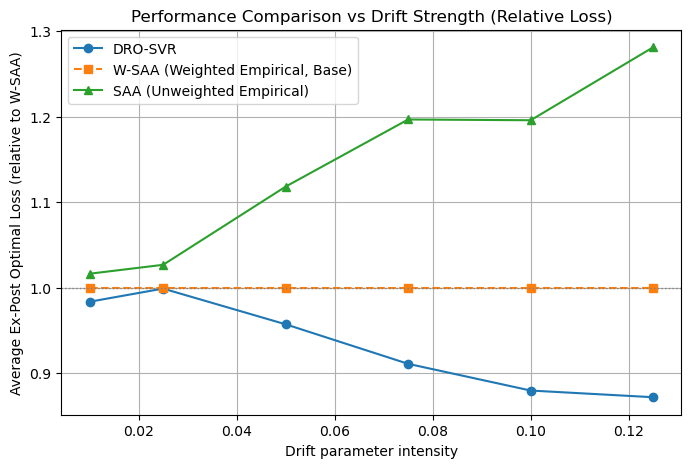

In [7]:
drift_params = list(avg_results_all_methods['DRO-SVR'].keys())
drift_params_array = np.array(drift_params)
w_saa_losses_array = np.array(list(avg_results_all_methods['W-SAA'].values()))

dro_svr_relative = np.array(list(avg_results_all_methods['DRO-SVR'].values())) / w_saa_losses_array
saa_relative = np.array(list(avg_results_all_methods['SAA'].values())) / w_saa_losses_array
w_saa_relative = np.ones_like(w_saa_losses_array)

plt.figure(figsize=(8,5))

plt.plot(drift_params_array, dro_svr_relative, marker='o', label='DRO-SVR')
plt.plot(drift_params_array, w_saa_relative, marker='s', linestyle='--', label='W-SAA (Weighted Empirical, Base)')
plt.plot(drift_params_array, saa_relative, marker='^', label='SAA (Unweighted Empirical)')

plt.axhline(y=1.0, color='gray', linestyle=':', linewidth=1) 

plt.xlabel("Drift parameter intensity")
plt.ylabel("Average Ex-Post Optimal Loss (relative to W-SAA)")
plt.title("Performance Comparison vs Drift Strength (Relative Loss)")
plt.legend()
plt.grid(True)
plt.show()

#### Parameters Setting

In [ ]:
rng = np.random.default_rng(seed=42)

# ------------------ basic settings ------------------
number_dimension = 5    # dim(x)
SAMPLES_PER_T = 40     # number of new samples at each time
T = 6                   # number of time steps
decay_rate = 0.9        # forgetting factor

# ------------------ drift hyperparameters ------------------
drift_scale_mu = np.array([1.0, 0.05, 0.3, 0.05, 0.01])   # drift intensity for each dimension
drift_scale_cov = 0.02                             # disturbance parameter for covariance

#### Train Set Construction

In [ ]:
# ------------------ initial Gaussian setup ------------------
mu_x = np.array([
    rng.uniform(80, 120),   # average area ~100 m2
    rng.uniform(3, 6),      # average number of rooms ~4-5
    rng.uniform(20, 50),    # average age of house ~30 years
    rng.uniform(2, 8),      # average distance from downtown ~5 km
    rng.uniform(0.4, 0.8)   # average renovation status ~0.6
])

A = rng.normal(0, 1, size=(number_dimension, number_dimension))
Sigma_x = A @ A.T + np.diag([30, 1, 15, 2, 0.1])  # add feature-specific variance to ensure realistic scale for each dimension

w_true = np.array([600, 5000, -200, -1000, 15000])         # price coefficients
sigma_w = 0.01 * np.linalg.norm(w_true) / np.sqrt(len(w_true))
sigma_eps = 8000.0                                             # noise std of y|x

# ------------------ container for time-varying data ------------------
mu_history = [mu_x.copy()]
Sigma_history = [Sigma_x.copy()]
w_true_history = [w_true.copy()]
data_stream = []

# ------------------ main time loop ------------------
for t in range(T):
    mu_x_t = mu_history[-1]
    Sigma_x_t = Sigma_history[-1]
    w_true_t = w_true_history[-1]

    # joint distribution parameters
    mu_y = float(mu_x_t @ w_true_t)
    Sigma_xy = Sigma_x_t @ w_true_t
    Sigma_yy = float(w_true_t.T @ Sigma_x_t @ w_true_t + sigma_eps**2)
    mu_joint = np.hstack([mu_x_t, mu_y])
    Sigma_joint = np.block([
        [Sigma_x_t,                 Sigma_xy.reshape(-1, 1)],
        [Sigma_xy.reshape(1, -1),   np.array([[Sigma_yy]])]
    ])

    # sample at this time t
    Z = rng.multivariate_normal(mean=mu_joint, cov=Sigma_joint, size=SAMPLES_PER_T)
    data_stream.append(Z)

    # drift the parameters for next step
    mu_next = mu_x_t + rng.normal(0, drift_scale_mu)
    Sigma_next = Sigma_x_t + drift_scale_cov * rng.normal(0, 1, size=Sigma_x_t.shape)
    Sigma_next = (Sigma_next + Sigma_next.T) / 2  # ensure symmetry
    Sigma_next = Sigma_next + np.eye(number_dimension) * 1e-6  # ensure positive definiteness
    w_true_next = w_true_t + rng.normal(0, sigma_w, size=w_true.shape)

    mu_history.append(mu_next)
    Sigma_history.append(Sigma_next)
    w_true_history.append(w_true_next)

#### Comparison of DRO Regression and Empirical Regression

In [ ]:
# ---------- Rolling Over Time ----------

X_all_list, y_all_list, Z_all_list, time_idx_list = [], [], [], []
w_series, w_emp_series = [], []
loss_mean_rob, loss_sem_rob = [], []
loss_mean_emp, loss_sem_emp = [], []

for t in range(T):
    # (1) sampling（sample SAMPLES_PER_T at each time）
    X_t, y_t, Z_t = sample_joint_gaussian(rng, mu_joint_hat, Sigma_joint_hat, SAMPLES_PER_T)

    # (2) history pool accumulation
    X_all_list.append(X_t)
    y_all_list.append(y_t)
    Z_all_list.append(Z_t)
    time_idx_list.append(np.full(SAMPLES_PER_T, t, dtype=int))

    # (3) merge all historical samples
    X_all = np.vstack(X_all_list)
    y_all = np.concatenate(y_all_list)
    Z_all = np.vstack(Z_all_list)
    time_idx = np.concatenate(time_idx_list)

    # (4) reconstruct the box uncertainty set Ξ from all historical samples
    ell, upp = build_box_uncertainty(Z_all, qmin=0.01, qmax=0.99, eta=0.02)
    C1, c2, d = build_box_conic_from_bounds(ell, upp, number_dimension)

    # (5) compute time-dependent sample weights
    pi_t = time_weights_from_indices(time_idx, now_t=t, decay=decay_rate)

    # (6) solve DRO-SVR (Corollary 3.3)
    w_t, status = solve_dro_svr_cor33(
        X_all, y_all, C1, c2, d, pi_t,
        epsilon=8000.0, rho=0.5, use_mosek=True
    )
    w_series.append(w_t)
    print(f"[t={t}] DRO-SVR (Cor 3.3) solved: status={status}, ||w||₂={np.linalg.norm(w_t):.3e}")

    # (7) solve empirical SVR (time-weighted, no regularization)
    w_emp, status_emp = solve_empirical_svr_noreg(
        X_all, y_all, epsilon=8000.0, sample_weights=pi_t
    )
    w_emp_series.append(w_emp)
    print(f"[t={t}] Empirical SVR solved: status={status_emp}, ||w||₂={np.linalg.norm(w_emp):.3e}")

    # (8) evaluate on current samples
    y_pred_rob = X_t @ w_t
    y_pred_emp = X_t @ w_emp
    L_t_rob = eps_ins_loss(y_t, y_pred_rob, eps=8000.0)
    L_t_emp = eps_ins_loss(y_t, y_pred_emp, eps=8000.0)
    loss_mean_rob.append(L_t_rob.mean())
    loss_sem_rob.append(L_t_rob.std(ddof=1) / np.sqrt(len(L_t_rob)))
    loss_mean_emp.append(L_t_emp.mean())
    loss_sem_emp.append(L_t_emp.std(ddof=1) / np.sqrt(len(L_t_emp)))

In [ ]:
# ---------- Visualization ----------

t_axis = np.arange(T)
plt.figure(figsize=(7, 4))

# DRO
plt.plot(t_axis, loss_mean_rob, marker="o", label="DRO robust (mean)")
plt.fill_between(t_axis,
                 np.array(loss_mean_rob)-np.array(loss_sem_rob),
                 np.array(loss_mean_rob)+np.array(loss_sem_rob),
                 alpha=0.25)

# Empirical
plt.plot(t_axis, loss_mean_emp, marker="s", label="Empirical no-reg (mean)")
plt.fill_between(t_axis,
                 np.array(loss_mean_emp)-np.array(loss_sem_emp),
                 np.array(loss_mean_emp)+np.array(loss_sem_emp),
                 alpha=0.25)

plt.xlabel("Time step t")
plt.ylabel("Average ε-insensitive loss")
plt.title("DRO (Cor.3.3) vs Empirical (time-weighted)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#### Test Set Construction

In [ ]:
def random_covariate_shift_matrix(dim, rng, scale_range=(0.7, 1.4), shear_std=0.2):
    # diagonal scaling
    scales = rng.uniform(scale_range[0], scale_range[1], size=dim)
    D = np.diag(scales)

    # shear (upper triangular with zeros on diag)
    S = np.triu(rng.normal(0.0, shear_std, size=(dim, dim)), k=1)
    A = D @ (np.eye(dim) + S)
    return A

def make_psd(S, eps=1e-10):
    S = 0.5 * (S + S.T)
    vals, vecs = np.linalg.eigh(S)
    vals = np.maximum(vals, eps)
    return (vecs * vals) @ vecs.T

# Non-orthogonal transform A for test
A = random_covariate_shift_matrix(number_dimension, rng, scale_range=(0.7, 1.4), shear_std=0.25)
# Test covariance under covariate shift
Sigma_x_test = A @ Sigma_x @ A.T

# Rebuild joint covariance for test
w_true_test = w_true.copy()
w_true_test[4] *= 0.6   # renovation impact ↓40%
w_true_test[2] *= 1.3   # age penalty ↑30%
w_true_test[3] *= 1.2   # distance penalty ↑20%

Sigma_xy_test = Sigma_x_test @ w_true_test
Sigma_yy_test = float(w_true_test.T @ Sigma_x_test @ w_true_test + sigma_eps**2)
mu_joint_test = np.hstack([mu_x, float(mu_x @ w_true_test)])

Sigma_joint_test = np.block([
    [Sigma_x_test,                 Sigma_xy_test.reshape(-1, 1)],
    [Sigma_xy_test.reshape(1, -1), np.array([[Sigma_yy_test]])]
])
Sigma_joint_test = make_psd(Sigma_joint_test)

N_test_total = 1000
X_test_all, y_test_all, Z_test_all = sample_joint_gaussian(
    rng, mu_joint_test, Sigma_joint_test, N_test_total
)

T_test = T
perm = rng.permutation(N_test_total)
splits = np.array_split(perm, T_test)

#### Evaluate DRO & Empirical models on the rotated test set

In [ ]:
test_mean_rob, test_sem_rob = [], []
test_mean_emp, test_sem_emp = [], []

for t in range(T_test):
    idx = splits[t]
    X_bin = X_test_all[idx]
    y_bin = y_test_all[idx]

    w_rob = w_series[t]
    w_emp = w_emp_series[t]

    y_rob_test_pred = X_bin @ w_rob
    y_emp_test_pred = X_bin @ w_emp

    L_rob_test = eps_ins_loss(y_bin, y_rob_test_pred, eps=8000.0)
    L_emp_test = eps_ins_loss(y_bin, y_emp_test_pred, eps=8000.0)

    test_mean_rob.append(L_rob_test.mean())
    test_sem_rob.append(L_rob_test.std(ddof=1) / np.sqrt(len(L_rob_test)))
    test_mean_emp.append(L_emp_test.mean())
    test_sem_emp.append(L_emp_test.std(ddof=1) / np.sqrt(len(L_emp_test)))

    print(f"[test-bin {t}] N={len(idx)} | mean loss DRO={test_mean_rob[-1]:.2f}, Emp={test_mean_emp[-1]:.2f}")

t_axis = np.arange(T_test)
plt.figure(figsize=(7, 4))
plt.plot(t_axis, test_mean_rob, marker="o", label="DRO robust (test mean)")
plt.fill_between(t_axis,
                 np.array(test_mean_rob) - np.array(test_sem_rob),
                 np.array(test_mean_rob) + np.array(test_sem_rob),
                 alpha=0.25)
plt.plot(t_axis, test_mean_emp, marker="s", label="Empirical no-reg (test mean)")
plt.fill_between(t_axis,
                 np.array(test_mean_emp) - np.array(test_sem_emp),
                 np.array(test_mean_emp) + np.array(test_sem_emp),
                 alpha=0.25)
plt.xlabel("Test bin (pseudo time)")
plt.ylabel("Average ε-insensitive loss")
plt.title("Covariate shift (non-orthogonal): test loss per bin")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()